In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0


/home/djjin/anaconda3/envs/conda_visual_HPE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch:  1.13 ; cuda:  cu117
detectron2: 0.6


In [2]:
from detectron2.utils.logger import setup_logger
setup_logger()

import argparse
import os, sys
import json
from pathlib import Path

home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
home_dir = os.path.abspath(os.getcwd())
sys.path.append(home_dir)
print(home_dir)

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.build import load_proposals_into_dataset

from utils.arguments import load_opt_from_config_files, load_config_dict_to_opt
from utils.distributed import init_distributed

/home/djjin/Mygit/X-Decoder/notebooks


Invalid MIT-MAGIC-COOKIE-1 key

In [3]:
parser = argparse.ArgumentParser(description='Pretrain or fine-tune models for NLP tasks.')
parser.add_argument('--command', default="evaluate", help='Command: train/evaluate/train-and-evaluate')
parser.add_argument('--conf_files', nargs='+', help='Path(s) to the config file(s).')
parser.add_argument('--user_dir', help='Path to the user defined module for tasks (models, criteria), optimizers, and lr schedulers.')
parser.add_argument('--config_overrides', nargs='*', help='Override parameters on config with a json style string, e.g. {"<PARAM_NAME_1>": <PARAM_VALUE_1>, "<PARAM_GROUP_2>.<PARAM_SUBGROUP_2>.<PARAM_2>": <PARAM_VALUE_2>}. A key with "." updates the object in the corresponding nested dict. Remember to escape " in command line.')
parser.add_argument('--overrides', help='arguments that used to override the config file in cmdline', nargs=argparse.REMAINDER)

cmdline_args = parser.parse_args('')
cmdline_args.conf_files = [os.path.join(home_dir, "../configs/xdecoder/svlp_focalt_lang.yaml")]
cmdline_args.overrides = ['WEIGHT', '../checkpoints/xdecoder_focalt_best_openseg.pt'] 
cmdline_args.overrides

['WEIGHT', '../checkpoints/xdecoder_focalt_best_openseg.pt']

In [4]:

opt = load_opt_from_config_files(cmdline_args.conf_files)

keys = [cmdline_args.overrides[idx*2] for idx in range(len(cmdline_args.overrides)//2)]
vals = [cmdline_args.overrides[idx*2+1] for idx in range(len(cmdline_args.overrides)//2)]
vals = [val.replace('false', '').replace('False','') if len(val.replace(' ', '')) == 5 else val for val in vals]
types = []
for key in keys:
    key = key.split('.')
    ele = opt.copy()
    while len(key) > 0:
        ele = ele[key.pop(0)]
    types.append(type(ele))

config_dict = {x:z(y) for x,y,z in zip(keys, vals, types)}
config_dict

load_config_dict_to_opt(opt, config_dict)
for key, val in cmdline_args.__dict__.items():
    if val is not None:
        opt[key] = val

opt = init_distributed(opt)

In [5]:
image_set="train"
num_queries = 100
root = Path(home_dir + "/../datasets/v-coco/")
PATHS = {
    'train': (root / 'images' / 'train2014', root / 'annotations' / 'trainval_vcoco.json'),
    'val': (root / 'images' / 'val2014', root / 'annotations' / 'test_vcoco.json')
}
img_folder, anno_file = PATHS[image_set]
img_folder, anno_file

(PosixPath('/home/djjin/Mygit/X-Decoder/notebooks/../datasets/v-coco/images/train2014'),
 PosixPath('/home/djjin/Mygit/X-Decoder/notebooks/../datasets/v-coco/annotations/trainval_vcoco.json'))

In [6]:
def load_vcoco_json(image_root, anno_file):
    json_file = os.path.join(anno_file)
    with open(json_file) as f:
        vcoco_anns = json.load(f)
    
    dataset_dicts = []
    for idx, v in enumerate(vcoco_anns):
        record = {}
        record["id"] = idx
        for key, val in v.items():
            if key == "file_name":
                record[key] = os.path.join(image_root, v["file_name"])
            else:
                record[key] = val
        dataset_dicts.append(record)
    return dataset_dicts

In [7]:
imgs_anns = load_vcoco_json(img_folder, anno_file)
imgs_anns

[{'id': 0,
  'file_name': '/home/djjin/Mygit/X-Decoder/notebooks/../datasets/v-coco/images/train2014/COCO_train2014_000000106497.jpg',
  'hoi_annotation': [{'subject_id': 1, 'category_id': 0, 'object_id': 4},
   {'subject_id': 1, 'category_id': 16, 'object_id': -1},
   {'subject_id': 1, 'category_id': 17, 'object_id': 2}],
  'annotations': [{'category_id': 44,
    'bbox': [431.77, 0.46, 504.81, 168.73000000000002]},
   {'category_id': 1,
    'bbox': [0.96, 1.07, 352.04999999999995, 145.35999999999999]},
   {'category_id': 59, 'bbox': [117.61, 175.46, 522.51, 332.6]},
   {'category_id': 73, 'bbox': [539.87, 82.91, 640.0, 184.13]},
   {'category_id': 47, 'bbox': [163.17, 50.3, 231.19, 116.42999999999999]},
   {'category_id': 47, 'bbox': [378.64, 7.9, 433.15, 135.09]}]},
 {'id': 1,
  'file_name': '/home/djjin/Mygit/X-Decoder/notebooks/../datasets/v-coco/images/train2014/COCO_train2014_000000270338.jpg',
  'hoi_annotation': [{'subject_id': 0, 'category_id': 0, 'object_id': 2},
   {'subject

In [8]:
def register_vcoco(name, metadata, image_root, annot_json):
    DatasetCatalog.register(
        name,
        lambda: load_vcoco_json(image_root, annot_json),
    )
    MetadataCatalog.get(name).set(
        image_root=image_root,
        json_file=annot_json,
        evaluator_type="vcoco",
        ignore_label=255,
        label_divisor=1000,
        **metadata,
    )

In [9]:
_PREDEFINED_SPLITS_VCOCO_CAPTION = {
    "vcoco_train": (
        "v-coco/images/train2014",
        "v-coco/annotations/trainval_vcoco.json"
    ),
    "vcoco_val": (
        "v-coco/images/val2014",
        "v-coco/annotations/test_vcoco.json"
    ),
}

In [10]:
def get_metadata():
    meta = {}
    return meta

In [11]:
def register_all_refcoco(root):
    for (
        prefix,
        (image_root, annot_root),
    ) in _PREDEFINED_SPLITS_VCOCO_CAPTION.items():
        register_vcoco(
            prefix,
            get_metadata(),
            os.path.join(root, image_root),
            os.path.join(root, annot_root),
        )

In [12]:
_root = os.getenv("DATASET", "../datasets")
register_all_refcoco(_root)

In [13]:
import itertools

def filter_images_with_only_crowd_annotations(dataset_dicts, dataset_names):
    def valid(anns):
        for ann in anns:
            if isinstance(ann, list):
                for instance in ann:
                    if instance.get("iscrowd", 0) == 0:
                        return True
            else:
                if ann.get("iscrowd", 0) == 0:
                    return True
        return False

    dataset_dicts = [x for x in dataset_dicts if valid(x["annotations"])]
    return dataset_dicts

def get_hoi_dataset_dicts(dataset_names, filter_empty=True, proposal_files=None):
    if isinstance(dataset_names, str):
        dataset_names = [dataset_names]
    assert len(dataset_names)
    
    dataset_dicts = [DatasetCatalog.get(dataset_name) for dataset_name in dataset_names]
    for dataset_name, dicts in zip(dataset_names, dataset_dicts):
        assert len(dicts), "Dataset '{}' is empty!".format(dataset_name)

    if proposal_files is not None:
        assert len(dataset_names) == len(proposal_files)
        # load precomputed proposals from proposal files
        dataset_dicts = [
            load_proposals_into_dataset(dataset_i_dicts, proposal_file)
            for dataset_i_dicts, proposal_file in zip(dataset_dicts, proposal_files)
        ]

    dataset_dicts = list(itertools.chain.from_iterable(dataset_dicts))

    has_instances = "annotations" in dataset_dicts[0]
    if filter_empty and has_instances:
        dataset_dicts = filter_images_with_only_crowd_annotations(dataset_dicts, dataset_names)

    assert len(dataset_dicts), "No valid data found in {}.".format(",".join(dataset_names))
    return dataset_dicts

In [14]:
hoi_dict = get_hoi_dataset_dicts("vcoco_train")
hoi_dict

[{'id': 0,
  'file_name': '../datasets/v-coco/images/train2014/COCO_train2014_000000106497.jpg',
  'hoi_annotation': [{'subject_id': 1, 'category_id': 0, 'object_id': 4},
   {'subject_id': 1, 'category_id': 16, 'object_id': -1},
   {'subject_id': 1, 'category_id': 17, 'object_id': 2}],
  'annotations': [{'category_id': 44,
    'bbox': [431.77, 0.46, 504.81, 168.73000000000002]},
   {'category_id': 1,
    'bbox': [0.96, 1.07, 352.04999999999995, 145.35999999999999]},
   {'category_id': 59, 'bbox': [117.61, 175.46, 522.51, 332.6]},
   {'category_id': 73, 'bbox': [539.87, 82.91, 640.0, 184.13]},
   {'category_id': 47, 'bbox': [163.17, 50.3, 231.19, 116.42999999999999]},
   {'category_id': 47, 'bbox': [378.64, 7.9, 433.15, 135.09]}]},
 {'id': 1,
  'file_name': '../datasets/v-coco/images/train2014/COCO_train2014_000000270338.jpg',
  'hoi_annotation': [{'subject_id': 0, 'category_id': 0, 'object_id': 2},
   {'subject_id': 1, 'category_id': 0, 'object_id': 2},
   {'subject_id': 0, 'category_i

In [15]:
from typing import Any, Callable, Dict, List, Optional, Union

import torch.utils.data as torchdata

from detectron2.data.build import trivial_batch_collator
from detectron2.data.common import DatasetFromList, MapDataset
from detectron2.data.dataset_mapper import DatasetMapper
from detectron2.data.samplers import InferenceSampler

from fvcore.common.config import CfgNode
from xdecoder.utils import configurable
from utils.distributed import get_world_size

def _test_loader_from_config(cfg, dataset_name, mapper=None):
    if isinstance(dataset_name, str):
        dataset_name = [dataset_name]

    dataset = get_hoi_dataset_dicts(
        dataset_name,
        filter_empty=False,
        proposal_files=None,
    )
    if mapper is None:
        mapper_cfg = CfgNode({'INPUT': cfg['INPUT'], 'MODEL': cfg['MODEL'], 'DATASETS': cfg['DATASETS']})
        mapper = DatasetMapper(mapper_cfg, False)
    assert cfg['TEST']['BATCH_SIZE_TOTAL'] % get_world_size() == 0, "Evaluation total batchsize is not divisible by gpu number"
    batch_size = cfg['TEST']['BATCH_SIZE_TOTAL'] // get_world_size()

    return {
        "dataset": dataset,
        "mapper": mapper,
        "num_workers": cfg['DATALOADER']['NUM_WORKERS'],
        "sampler": InferenceSampler(len(dataset)),
        "batch_size": batch_size,
    }

@configurable(from_config=_test_loader_from_config)
def build_hoi_test_loader(
    dataset: Union[List[Any], torchdata.Dataset],
    *,
    mapper: Callable[[Dict[str, Any]], Any],
    sampler: Optional[torchdata.Sampler] = None,
    batch_size: int = 1,
    num_workers: int = 0,
    collate_fn: Optional[Callable[[List[Any]], Any]] = None,
) -> torchdata.DataLoader:

    if isinstance(dataset, list):
        dataset = DatasetFromList(dataset, copy=False)
    if mapper is not None:
        dataset = MapDataset(dataset, mapper)
    if isinstance(dataset, torchdata.IterableDataset):
        assert sampler is None, "sampler must be None if dataset is IterableDataset"
    else:
        if sampler is None:
            sampler = InferenceSampler(len(dataset))
    return torchdata.DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=sampler,
        drop_last=False,
        num_workers=num_workers,
        collate_fn=trivial_batch_collator if collate_fn is None else collate_fn,
    )

In [16]:
# --------------------------------------------------------
# X-Decoder -- Generalized Decoding for Pixel, Image, and Language
# Copyright (c) 2022 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Modified by Xueyan Zou (xueyan@cs.wisc.edu)
# --------------------------------------------------------
# Copyright (c) Facebook, Inc. and its affiliates.
import copy
import random

import scipy.io
import numpy as np
import torch
from PIL import Image

from torchvision import transforms

from pycocotools import mask
from detectron2.data import detection_utils as utils
from datasets.utils import transforms as T

from xdecoder.utils import configurable

__all__ = ["VCOCODatasetMapper"]



class VCOCODatasetMapper:
    @configurable
    def __init__(
        self,
        is_train=True,
        min_size_test=None,
        max_size_test=None,
    ):
        """
        NOTE: this interface is experimental.
        Args:
            is_train: for training or inference
            augmentations: a list of augmentations or deterministic transforms to apply
            tfm_gens: data augmentation
            image_format: an image format supported by :func:`detection_utils.read_image`.
        """
        self.is_train = is_train
        self.min_size_test = min_size_test
        self.max_size_test = max_size_test
        self.num_queries = num_queries

        self._valid_obj_ids = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,
                               14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                               24, 25, 27, 28, 31, 32, 33, 34, 35, 36,
                               37, 38, 39, 40, 41, 42, 43, 44, 46, 47,
                               48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
                               58, 59, 60, 61, 62, 63, 64, 65, 67, 70,
                               72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                               82, 84, 85, 86, 87, 88, 89, 90)
        self._valid_verb_ids = range(29)
        self._transforms = self.make_vcoco_transforms(is_train)

    @classmethod
    def from_config(cls, cfg, is_train=True):
        ret = {
            "is_train": is_train,
            "min_size_test": cfg['INPUT']['MIN_SIZE_TEST'],
            "max_size_test": cfg['INPUT']['MAX_SIZE_TEST'],
        }
        return ret
    
    @staticmethod
    def make_vcoco_transforms(is_train):

        normalize = T.Compose([
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        scales = [480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800]

        if is_train:
            return T.Compose([
                T.RandomHorizontalFlip(),
                T.ColorJitter(.4, .4, .4),
                T.RandomSelect(
                    T.RandomResize(scales, max_size=1333),
                    T.Compose([
                        T.RandomResize([400, 500, 600]),
                        T.RandomSizeCrop(384, 600),
                        T.RandomResize(scales, max_size=1333),
                    ])
                ),
                normalize,
            ])
        else:
            return T.Compose([
                T.RandomResize([800], max_size=1333),
                normalize,
            ])

        raise ValueError(f'unknown {image_set}')

    def __call__(self, dataset_dict):
        """
        Args:
            dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.

        Returns:
            dict: a format that builtin models in detectron2 accept
        """
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        file_name = dataset_dict['file_name']
        img = Image.open(file_name).convert('RGB')
        w, h = img.size

        boxes = [obj['bbox'] for obj in dataset_dict['annotations']]
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)

        if self.is_train:
            # Add index for confirming which boxes are kept after image transformation
            classes = [(i, self._valid_obj_ids.index(obj['category_id'])) for i, obj in enumerate(dataset_dict['annotations'])]
        else:
            classes = [self._valid_obj_ids.index(obj['category_id']) for obj in dataset_dict['annotations']]
        classes = torch.tensor(classes, dtype=torch.int64)


        target = {}
        target['orig_size'] = torch.as_tensor([int(h), int(w)])
        target['size'] = torch.as_tensor([int(h), int(w)])

        if self.is_train:
            boxes[:, 0::2].clamp_(min=0, max=w)
            boxes[:, 1::2].clamp_(min=0, max=h)
            keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
            boxes = boxes[keep]
            classes = classes[keep]

            target['boxes'] = boxes
            target['labels'] = classes
            target['iscrowd'] = torch.tensor([0 for _ in range(boxes.shape[0])])
            target['area'] = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

            if self._transforms is not None:
                img, target = self._transforms(img, target)

            kept_box_indices = [label[0] for label in target['labels']]

            target['labels'] = target['labels'][:, 1]

            obj_labels, verb_labels, sub_boxes, obj_boxes = [], [], [], []
            sub_obj_pairs = []
            for hoi in dataset_dict['hoi_annotation']:
                if hoi['subject_id'] not in kept_box_indices or \
                   (hoi['object_id'] != -1 and hoi['object_id'] not in kept_box_indices):
                    continue
                sub_obj_pair = (hoi['subject_id'], hoi['object_id'])
                if sub_obj_pair in sub_obj_pairs:
                    verb_labels[sub_obj_pairs.index(sub_obj_pair)][self._valid_verb_ids.index(hoi['category_id'])] = 1
                else:
                    sub_obj_pairs.append(sub_obj_pair)
                    if hoi['object_id'] == -1:
                        obj_labels.append(torch.tensor(len(self._valid_obj_ids)))
                    else:
                        obj_labels.append(target['labels'][kept_box_indices.index(hoi['object_id'])])
                    verb_label = [0 for _ in range(len(self._valid_verb_ids))]
                    verb_label[self._valid_verb_ids.index(hoi['category_id'])] = 1
                    sub_box = target['boxes'][kept_box_indices.index(hoi['subject_id'])]
                    if hoi['object_id'] == -1:
                        obj_box = torch.zeros((4,), dtype=torch.float32)
                    else:
                        obj_box = target['boxes'][kept_box_indices.index(hoi['object_id'])]
                    verb_labels.append(verb_label)
                    sub_boxes.append(sub_box)
                    obj_boxes.append(obj_box)

            target['filename'] = dataset_dict['file_name']
            if len(sub_obj_pairs) == 0:
                target['obj_labels'] = torch.zeros((0,), dtype=torch.int64)
                target['verb_labels'] = torch.zeros((0, len(self._valid_verb_ids)), dtype=torch.float32)
                target['sub_boxes'] = torch.zeros((0, 4), dtype=torch.float32)
                target['obj_boxes'] = torch.zeros((0, 4), dtype=torch.float32)
                target['matching_labels'] = torch.zeros((0,), dtype=torch.int64)
            else:
                target['obj_labels'] = torch.stack(obj_labels)
                target['verb_labels'] = torch.as_tensor(verb_labels, dtype=torch.float32)
                target['sub_boxes'] = torch.stack(sub_boxes)
                target['obj_boxes'] = torch.stack(obj_boxes)
                target['matching_labels'] = torch.ones_like(target['obj_labels'])
        else:
            target['filename'] = dataset_dict['file_name']
            target['boxes'] = boxes
            target['labels'] = classes
            target['id'] = dataset_dict['id']
            target['img_id'] = int(dataset_dict['file_name'].rstrip('.jpg').split('_')[2])

            if self._transforms is not None:
                img, _ = self._transforms(img, None)

            hois = []
            for hoi in dataset_dict['hoi_annotation']:
                hois.append((hoi['subject_id'], hoi['object_id'], self._valid_verb_ids.index(hoi['category_id'])))
            target['hois'] = torch.as_tensor(hois, dtype=torch.int64)
            
        dataset_dict["image"] = img
        dataset_dict["instances"] = target
        return dataset_dict

datasets/ADE20K_2021_17_01/images_detectron2/training
datasets/ADE20K_2021_17_01/images_detectron2/validation


In [17]:
opt['DATASETS']['Train'] = ['vcoco_train']
dataset_names = opt['DATASETS']['Train']
opt.update(opt['VCOCO'])
mapper = VCOCODatasetMapper(opt, True)
dataloaders = [build_hoi_test_loader(opt, dataset_names, mapper=mapper)]
dataloaders

[07/12 16:03:14 d2.data.common]: Serializing 5400 elements to byte tensors and concatenating them all ...
[07/12 16:03:14 d2.data.common]: Serialized dataset takes 3.62 MiB


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


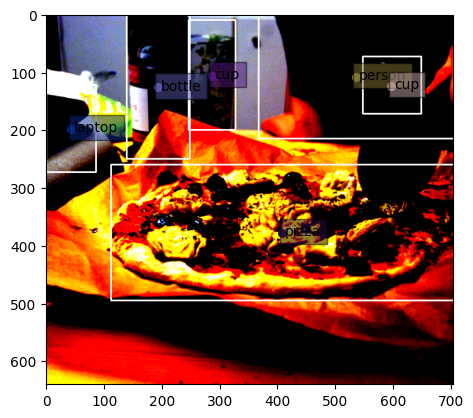

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


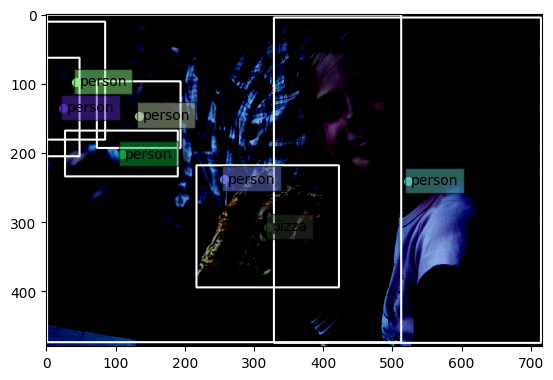

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


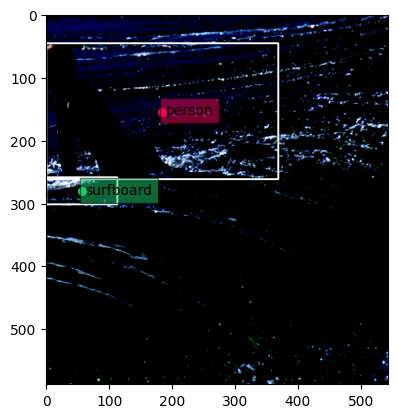

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


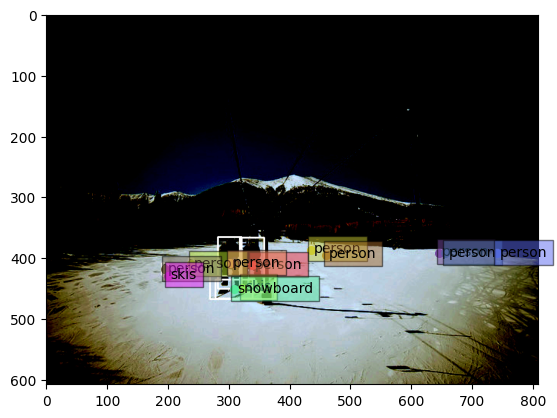

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


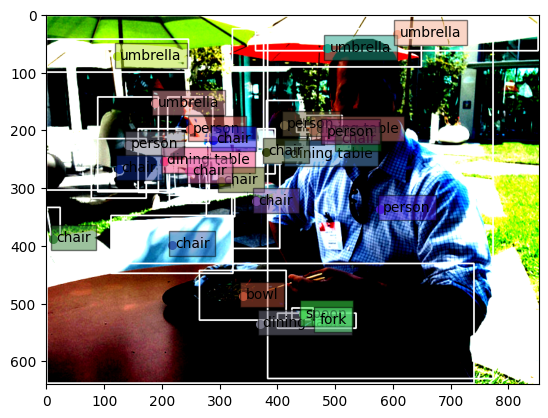

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


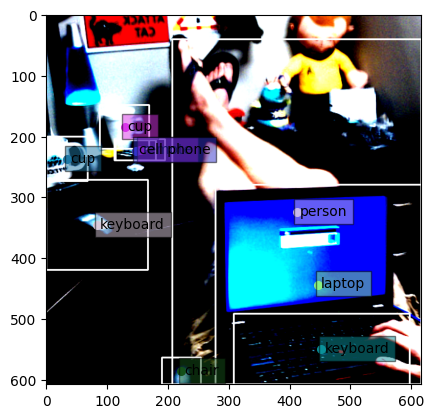

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


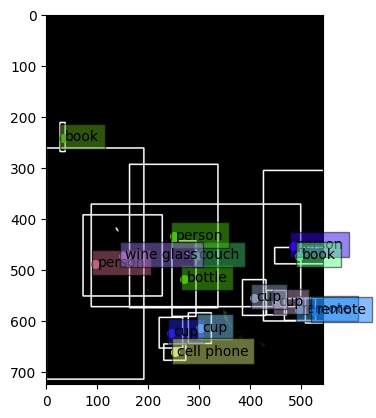

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


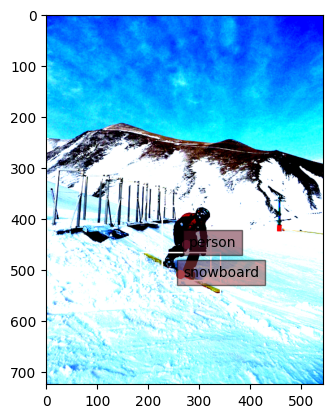

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


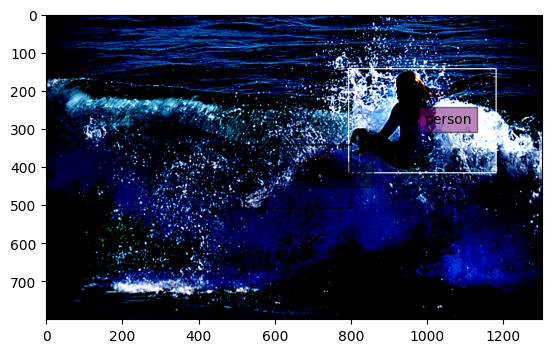

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


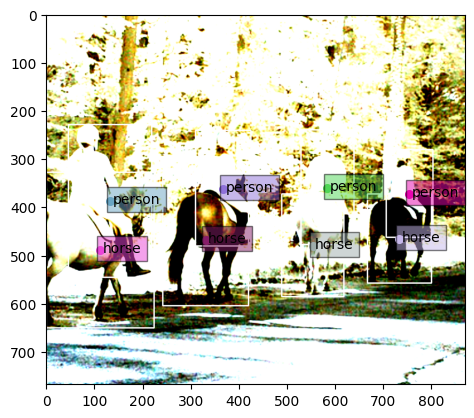

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


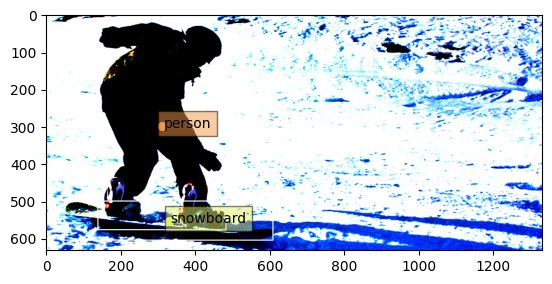

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


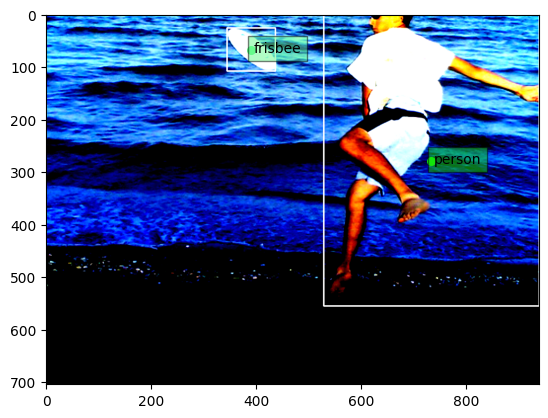

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


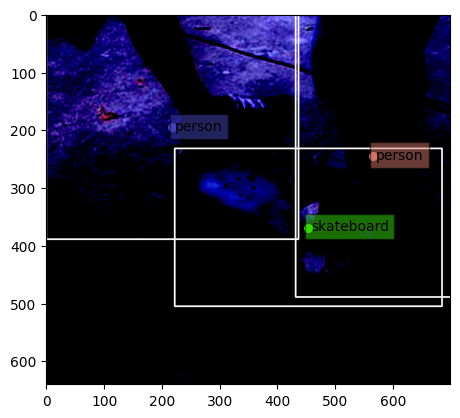

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


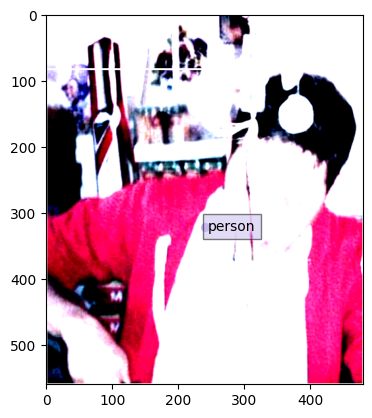

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


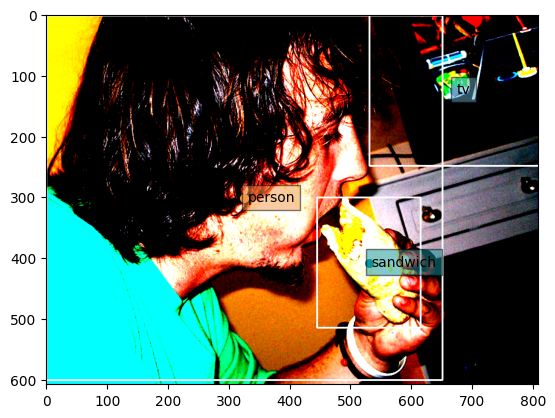

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


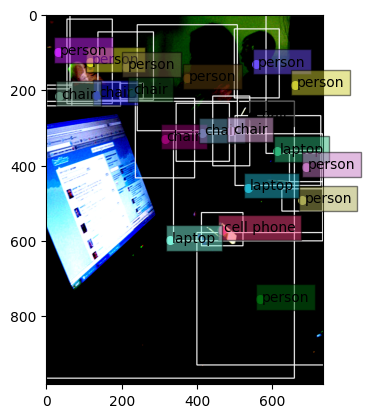

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


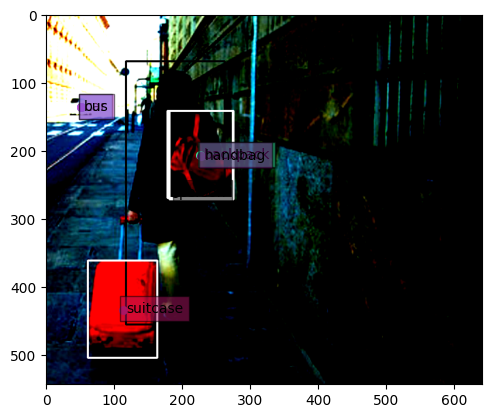

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


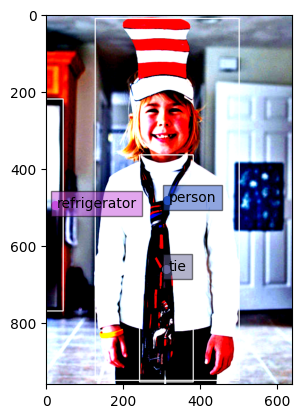

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


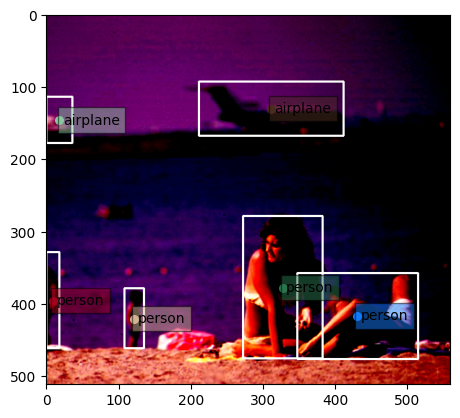

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

In [18]:
import cv2
from datasets.utils.vcoco_utils import valid_obj_ids, get_coco_instance_ID_to_name
from matplotlib import pyplot as plt
def random_color():
    rdn = random.randint(1, 1000)
    b = int(rdn * 997) % 255
    g = int(rdn * 4447) % 255
    r = int(rdn * 6563) % 255
    return b, g, r


for dataloader, dataset_name in zip(dataloaders, dataset_names):
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            for test in batch:
                target_img = test["image"]
                target = test["instances"]
                img = target_img.permute(1, 2, 0).detach().cpu().numpy()
                hh, ww = img.shape[0], img.shape[1]
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

                obj_labels = []
                labels = []
                verb_names = []
                ob_boxes = []
                sub_boxes = []

                obj_boxes = target['boxes']
                for test in range(obj_boxes.shape[0]):
                    cx, cy, w, h = obj_boxes[test]
                    color = random_color()
                    cx, cy, w, h = cx * ww, cy * hh, w * ww, h * hh
                    n_box = list(map(int, [cx - 0.5 * w, cy - 0.5 * h, cx + 0.5 * w, cy + 0.5 * h]))
                    x1, y1, x2, y2 = n_box
                    ob_boxes.append(n_box)

                for idx in target['labels']:
                    label_name = get_coco_instance_ID_to_name(valid_obj_ids[idx])
                    labels.append(label_name)

                for label, box in zip(labels, ob_boxes):
                    color = random_color()
                    x1, y1, x2, y2 = box
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    x = (x1 + x2) / 2
                    y = (y1 + y2) / 2

                    plt.scatter(x, y, 30, color=[i/255 for i in color])
                    plt.text(
                        x + 5,
                        y + 5,
                        label,
                        fontsize=10,
                        bbox=dict(facecolor=[i/255 for i in color], alpha=0.5),
                        )

                plt.imshow(img)
                plt.show()
                